#**A. Pre-Requisites**

In [ ]:
%%capture

# 1. Kaggle Installation
!pip install kaggle

# 2. Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# 3. Download Kaggle data directly into Google Colab
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/COMP700/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# **B. Install the Required Libraries**

In [ ]:
%%capture

# SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git

# Transformers
!pip install -q git+https://github.com/huggingface/transformers.git

# Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai

# Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify
!pip install nibabel

# **1. Load Databases**

# **1.1. Image Segmentation Dataset**

Consists of the following datasets:


*   CVC-ClinicDB
*   CVC-ColonDB
*   ETIS-LaribPolypDB
*   Kvasir-Sessile
*   Kvasir-Seg



## Download Dataset

In [ ]:
!kaggle datasets download dntai2/image-poplyp-segmentation
!unzip -q image-poplyp-segmentation.zip

Dataset URL: https://www.kaggle.com/datasets/dntai2/image-poplyp-segmentation
License(s): apache-2.0
 99% 434M/438M [00:13<00:00, 43.8MB/s]
100% 438M/438M [00:13<00:00, 33.2MB/s]


## **1.1.1 CVC-ColonDB Dataset**

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/CVC-ColonDB/CVC-ColonDB/images'  # Directory with image .png files
mask_dir = '/content/CVC-ColonDB/CVC-ColonDB/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 380 images of shape (256, 256) (HxW)
Loaded 380 masks of shape (256, 256) (HxW)
Image shape: (380, 256, 256)
Mask shape: (380, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 380
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/colondb_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/colondb_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 380
})

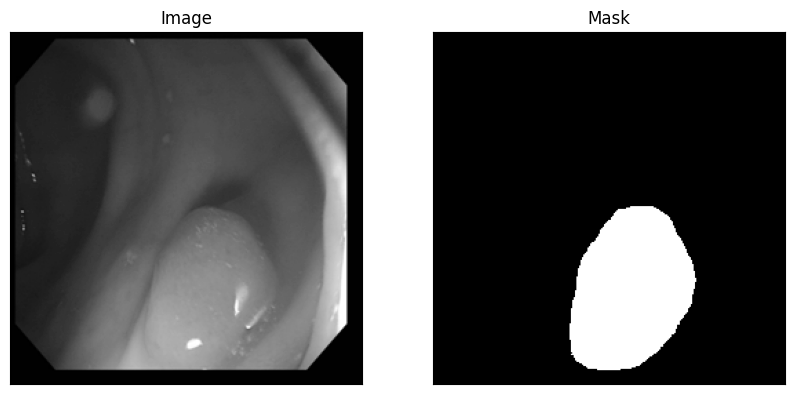

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **1.1.2. ETIS-LaribPolypDB**

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/ETIS-LaribPolypDB/ETIS-LaribPolypDB/images'  # Directory with image .png files
mask_dir = '/content/ETIS-LaribPolypDB/ETIS-LaribPolypDB/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 196 images of shape (256, 256) (HxW)
Loaded 196 masks of shape (256, 256) (HxW)
Image shape: (196, 256, 256)
Mask shape: (196, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/etis_polyp_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/etis_polyp_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})

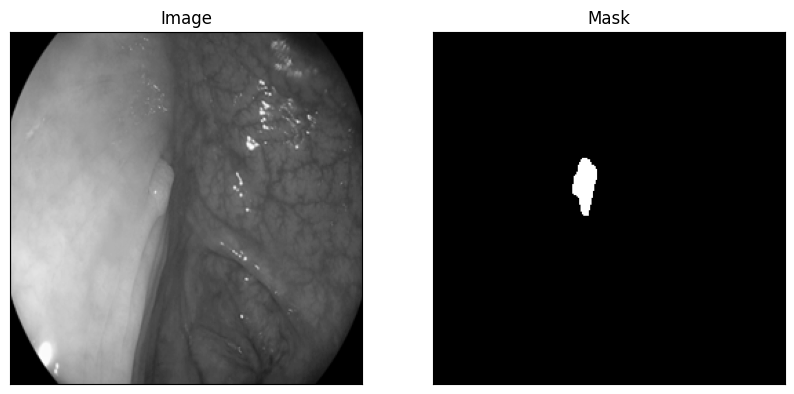

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **1.1.3. Kvasir-Sessile Dataset**

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/kvasir-sessile/sessile-main-Kvasir-SEG/images'  # Directory with image .png files
mask_dir = '/content/kvasir-sessile/sessile-main-Kvasir-SEG/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 196 images of shape (256, 256) (HxW)
Loaded 196 masks of shape (256, 256) (HxW)
Image shape: (196, 256, 256)
Mask shape: (196, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_sessile_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_sessile_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 196
})

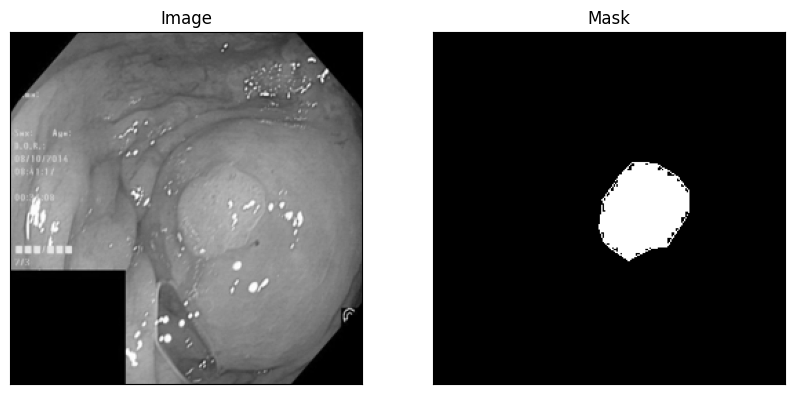

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## **1.1.4. CVC-ClinicDB Dataset**

### Create Dataset

In [ ]:
import os
import numpy as np
import imageio
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .tif images
image_dir = '/content/CVC-ClinicDB/CVC-ClinicDB/Original'  # Directory with image .tif files
mask_dir = '/content/CVC-ClinicDB/CVC-ClinicDB/Ground Truth'    # Directory with mask .tif files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.tif'):  # Check for .tif files
            img_path = os.path.join(folder, filename)
            try:
                img = imageio.imread(img_path)  # Use imageio to read the image
                img = Image.fromarray(img).convert('L')  # Convert to grayscale
                img = img.resize(target_size)  # Resize to the target size
                img_np = np.array(img)
                images.append(img_np)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


<ipython-input-27-25f4cedeb682>:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(img_path)  # Use imageio to read the image


Loaded 612 images of shape (256, 256) (HxW)
Loaded 612 masks of shape (256, 256) (HxW)
Image shape: (612, 256, 256)
Mask shape: (612, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 612
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as .npz
#np.savez('/content/drive/MyDrive/COMP700/EfficientSAM/kvasir_dataset.npz', images=images, labels=labels)

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_tif_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/cvc_tif_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 612
})

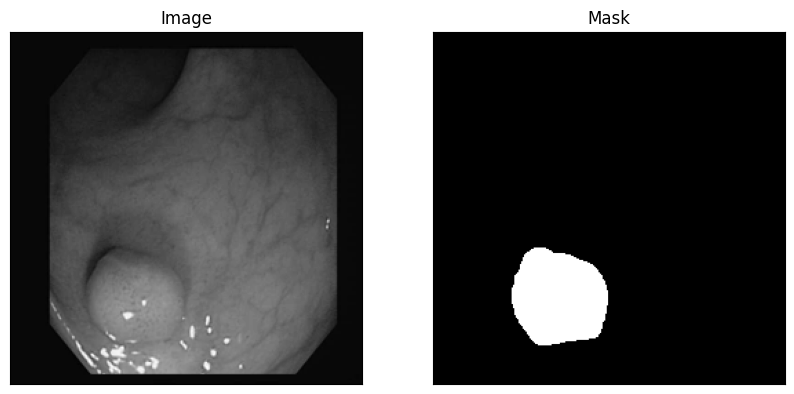

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **1.2. Polyps Segmentation Dataset**

## Download Dataset

In [ ]:
!kaggle datasets download mdsahilurrahman71/polyps-seg
!unzip -q polyps-seg.zip

Dataset URL: https://www.kaggle.com/datasets/mdsahilurrahman71/polyps-seg
License(s): Attribution 4.0 International (CC BY 4.0)
 52% 1.00M/1.91M [00:00<00:00, 1.97MB/s]
100% 1.91M/1.91M [00:00<00:00, 3.20MB/s]


## Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/polyps'  # Directory with image .png files
mask_dir = '/content/mask'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 50 images of shape (256, 256) (HxW)
Loaded 50 masks of shape (256, 256) (HxW)
Image shape: (50, 256, 256)
Mask shape: (50, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50
})

## Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polyp_seg_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polyp_seg_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 50
})

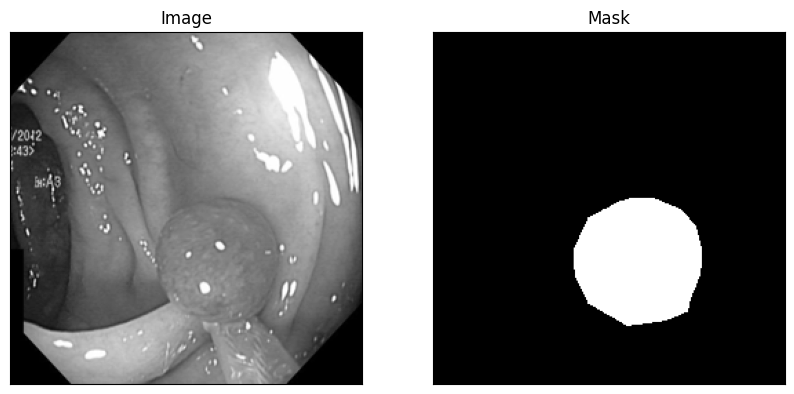

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# **1.3. PolypDB Dataset**

5 modalities include:


*   Blue Light Imaging (BLI),
*   Flexible Imaging Color Enhancement (FICE),
*   Linked Color Imaging (LCI),
*   Narrow Band Imaging (NBI),
*   White Light Imaging (WLI)

3 medical centres:
*   Norway
*   Sweden
*   Vietnam



## Download Dataset

In [ ]:
!kaggle datasets download debeshjha1/polypdb
!unzip -q polypdb.zip

Dataset URL: https://www.kaggle.com/datasets/debeshjha1/polypdb
License(s): unknown
polypdb.zip: Skipping, found more recently modified local copy (use --force to force download)


## Modalities

Will be only looking at Modality-Wise

## 1.3.1. BLI (Blue Light Imaging)

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/BLI/images'  # Directory with image .png files
mask_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/BLI/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 70 images of shape (256, 256) (HxW)
Loaded 70 masks of shape (256, 256) (HxW)
Image shape: (70, 256, 256)
Mask shape: (70, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_bli_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_bli_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70
})

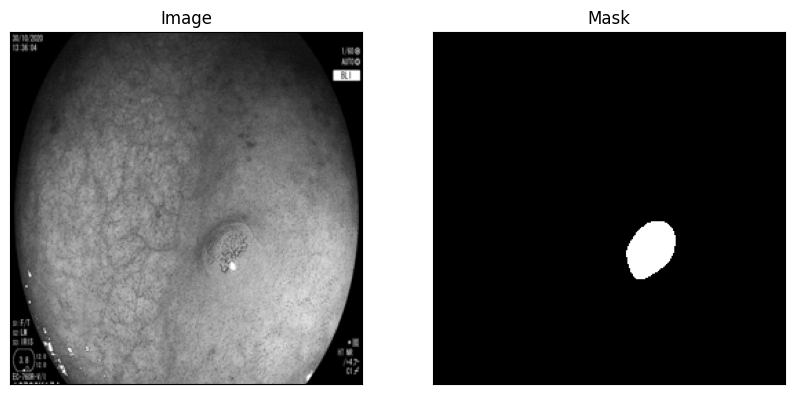

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## 1.3.2. FICE (Flexible Imaging Color Enhancement)

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/FICE/images'  # Directory with image .png files
mask_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/FICE/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 70 images of shape (256, 256) (HxW)
Loaded 70 masks of shape (256, 256) (HxW)
Image shape: (70, 256, 256)
Mask shape: (70, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_fice_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_fice_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 70
})

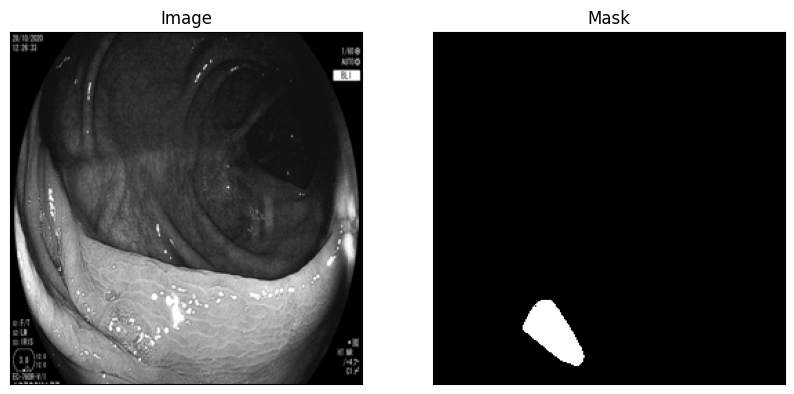

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## 1.3.3. LCI (Linked Color Imaging)

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/LCI/images'  # Directory with image .png files
mask_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/LCI/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 60 images of shape (256, 256) (HxW)
Loaded 60 masks of shape (256, 256) (HxW)
Image shape: (60, 256, 256)
Mask shape: (60, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_lci_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_lci_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 60
})

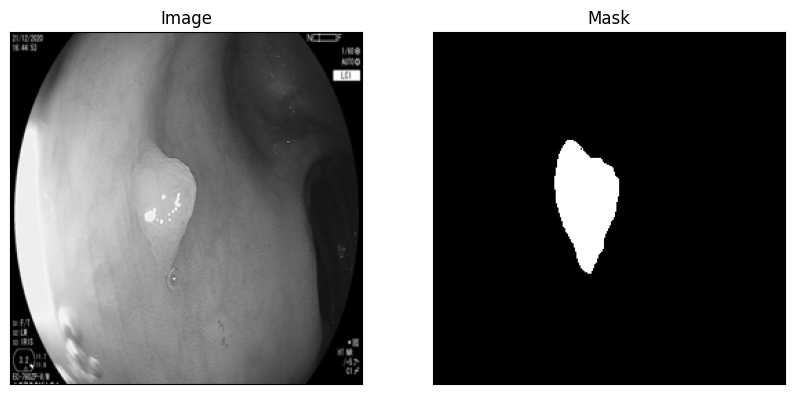

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## 1.3.4. NBI (Narrow Band Imaging)

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/NBI/images'  # Directory with image .png files
mask_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/NBI/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 146 images of shape (256, 256) (HxW)
Loaded 146 masks of shape (256, 256) (HxW)
Image shape: (146, 256, 256)
Mask shape: (146, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_nbi_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_nbi_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 146
})

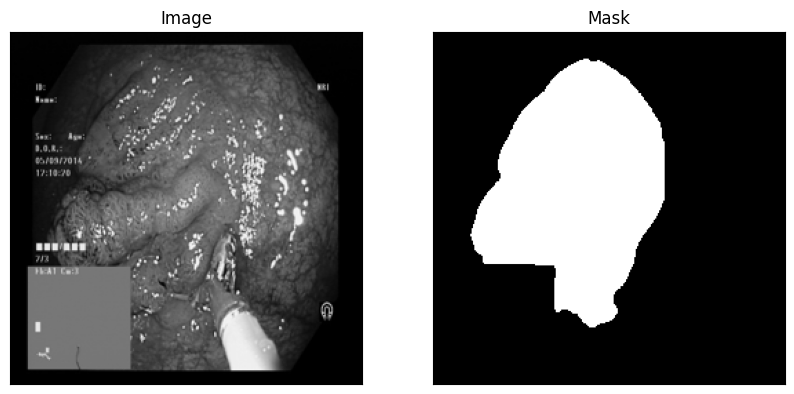

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

## 1.3.5. WLI (White Light Imaging)

### Create Dataset

In [ ]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
from datasets import Dataset

# Define paths to the directories containing .PNG images
image_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/WLI/images'  # Directory with image .png files
mask_dir = '/content/PolypDB/PolypDB/PolypDB_modality_wise/WLI/masks'    # Directory with mask .png files

# Desired patch size and step size
patch_size = 256
step = 256
resize_to = (256, 256)  # Define a common size for all images and masks

# Function to load and resize images from a folder
def load_images_from_folder(folder, target_size):
    images = []
    for filename in sorted(os.listdir(folder)):  # Sorting ensures consistent order
        if filename.endswith('.png') or filename.endswith('.jpg'):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img = img.resize(target_size)  # Resize to the target size
            img_np = np.array(img)
            images.append(img_np)
    return np.array(images)

# Load and resize images and masks
large_images = load_images_from_folder(image_dir, resize_to)
large_masks = load_images_from_folder(mask_dir, resize_to)

# Check loaded image and mask shapes
print(f"Loaded {large_images.shape[0]} images of shape {large_images.shape[1:]} (HxW)")
print(f"Loaded {large_masks.shape[0]} masks of shape {large_masks.shape[1:]} (HxW)")

# Extract patches for images
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i, j, :, :]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

# Extract patches for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  # No overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):
            single_patch_mask = patches_mask[i, j, :, :]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)  # Normalize to 0-1 range
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

# Filter non-empty masks and corresponding images
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]

# Print the shapes of the filtered image and mask arrays
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width)
print("Mask shape:", filtered_masks.shape)

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)


Loaded 3588 images of shape (256, 256) (HxW)
Loaded 3588 masks of shape (256, 256) (HxW)
Image shape: (3588, 256, 256)
Mask shape: (3588, 256, 256)


In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3588
})

### Save Dataset

In [ ]:
from google.colab import drive
import numpy as np
import pickle

drive.mount('/content/drive')

# Save as pickle file
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_wli_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_dict, f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load Dataset

In [ ]:
import pickle
from datasets import Dataset
from google.colab import drive

#drive.mount('/content/drive')

# Reload the dataset dictionary from pickle
with open('/content/drive/MyDrive/COMP700/EfficientSAM/polypdb_wli_dataset.pkl', 'rb') as f:
    dataset_dict = pickle.load(f)

# Recreate the Dataset object
dataset = Dataset.from_dict(dataset_dict)

dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 3588
})

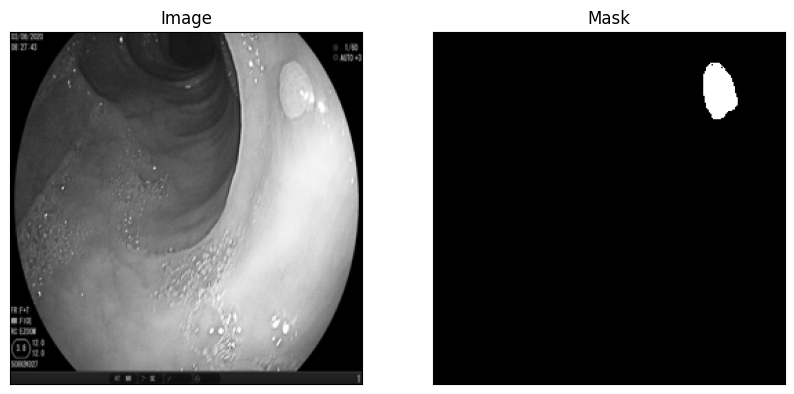

In [ ]:
import random  # Import the random module
import matplotlib.pyplot as plt
import numpy as np

img_num = random.randint(0, len(dataset)-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()